In [1]:
import numpy as np
import matplotlib
print(matplotlib.matplotlib_fname())
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from physics.mkid import model
from kid_readout.analysis import dataframe

/home/flanigan/.config/matplotlib/matplotlibrc
no data directory set up for artemis.phys.columbia.edu defaulting to /data
updated file list


/home/flanigan/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
df = pd.DataFrame.from_records(np.load('/data/readout/archive/2016-03-01_103311_cw_noise_test.npy'))

In [3]:
df.shape

(1472, 93)

In [4]:
np.unique(df.timestream_modulation_duty_cycle)

array([ 0. ,  0.5])

In [5]:
df['resonator_id'] = df['resonator_id'] + 16*(df.f_0 > 1300)
df['zbd_voltage'].loc[df.timestream_modulation_duty_cycle==0] = df['zbd_voltage'][df.timestream_modulation_duty_cycle==0.5].values

/home/flanigan/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
np.unique(df.resonator_id)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [7]:
np.unique(df.resonator_index)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [8]:
dataframe.rename_f(df)
dataframe.add_Q_i_err(df)
#dataframe.add_channel(df)
dataframe.add_resonator_fit_good(df, maximum_fractional_f_r_error=1e-5, maximum_iQi_error=1e-5)

In [9]:
np.unique(df.timestream_mmw_source_freq)

array([  0.00000000e+00,   1.48000000e+11])

In [10]:
nu = df.timestream_mmw_source_freq.max()

In [11]:
df = dataframe.analyze_mmw_source_data(df=df, zbd_fraction=0.99, optical_frequency=nu)

In [12]:
good = (df.resonator_fit_good &
        (df.timestream_modulation_duty_cycle == 0))
min_power = df.source_power == df.source_power.min()
max_power = df.source_power == df.source_power.max()

#        (df.f_r < 1300))
#        (df.resonator_id==2)

In [13]:
sum(good)

668

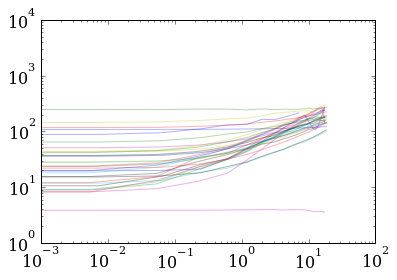

In [14]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for r_id in np.unique(df.resonator_id):
    id_mask = df.resonator_id == r_id
    ax.plot(1e6 * df[good & id_mask].source_power,
         1e6 / df[good & id_mask].Q_i, '-', alpha=0.3)

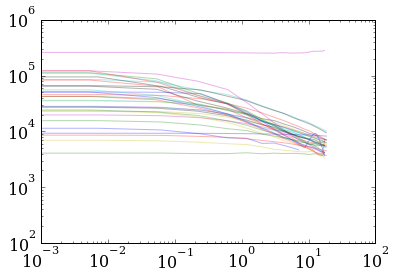

In [15]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for r_id in np.unique(df.resonator_id):
    id_mask = df.resonator_id == r_id
    ax.plot(1e6 * df[good & id_mask].source_power,
            df[good & id_mask].Q_i, '-', alpha=0.3)

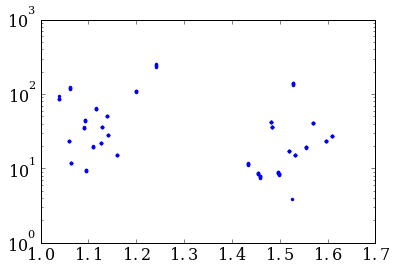

In [16]:
fig, ax = plt.subplots()
ax.set_yscale('log')
good_min = df[good & min_power]
ax.plot(1e-3 * good_min.f_r,
        1e6 / good_min.Q_i, '.')

mean f_r = 1122 MHz
mean iQi = 0.000164


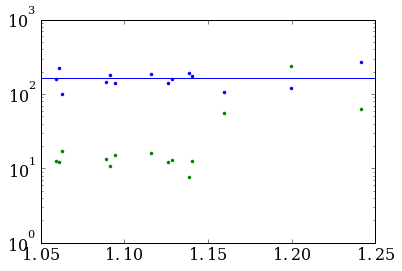

In [17]:
fig, ax = plt.subplots()
ax.set_yscale('log')

good_max = df[good & max_power]

ax.plot(1e-3 * good_max.f_r,
        1e6 / good_max.Q_i, '.')
ax.plot(1e-3 * good_max.f_r,
        1e6 / good_max.Q_e_real, '.')

max_mean_iQi = np.mean(1 / good_max.Q_i)
max_mean_f_r = np.mean(good_max.f_r)
ax.axhline(1e6 * max_mean_iQi)
#max_mean_iQc = np.mean(1 / good_max[good_max.f_r < 1.15e3].Q_e_real)
print("mean f_r = {:.0f} MHz".format(max_mean_f_r))
print("mean iQi = {:.3g}".format(max_mean_iQi))

# Compare to model

In [18]:
np.unique(df.sweep_primary_package_temperature)

array([ 0.18603549,  0.18606701,  0.18624554,  0.186366  ,  0.1863661 ,
        0.18643121,  0.18654334,  0.1866293 ,  0.18663689,  0.18680031,
        0.1868651 ,  0.18693017,  0.18699921,  0.18730394,  0.18730739,
        0.18734301,  0.18748924,  0.18763929,  0.18777594,  0.18800054,
        0.18834496,  0.18834993,  0.18843361,  0.18852779,  0.18867568,
        0.18892277,  0.18896499,  0.18902546,  0.18904766,  0.18945317,
        0.18952941,  0.18973896,  0.1906042 ,  0.19072097,  0.19099166,
        0.19112271,  0.19119884,  0.19135066,  0.19173926,  0.19191628,
        0.19232881,  0.19233375,  0.19272544,  0.19323663,  0.19345874,
        0.19359362])

In [19]:
# Calculate the absorbed power, assuming the same system transmission as in the paper,
# which used the same optical frequency of 148 GHz.
apl_eta_148 = 1.12e-6
eta = apl_eta_148 / 2  # Account for the power being split due to the 45 degree illumination
P_max = eta * df.source_power.max()
print("maximum absorbed power = {:.1f} pW".format(1e12 * P_max))

maximum absorbed power = 10.3 pW


In [20]:
# Values from Glenn
inductor_length_um = 5200
inductor_width_um = 2
thickness_um = 0.04
#geometric_inductance = 4e-9
#L_g_per_um = geometric_inductance / inductor_length_um  # inductance per unit length, in henries
nominal_volume_um3 = inductor_width_um * inductor_length_um * thickness_um
print("nominal volume = {:.0f} um^3".format(nominal_volume_um3))

# Assumed values
T_c = 1.3
T_substrate = df.sweep_primary_package_temperature.mean()
#phonon_trapping_factor = 1  # see below
alpha = 0.5
f_r = 1e6 * max_mean_f_r  # convert from MHz
iQc = 15e-6  # from plot
iQi0 = 10e-6  # this seems to vary widely
S_TLS_at_P_c = 1e-19  # negligible
P_c = 1e-13

V = np.linspace(nominal_volume_um3, 100 * nominal_volume_um3, 1e3)

nominal volume = 416 um^3


In [21]:
kid1 = model.KID(active_metal=model.Aluminum(T_c=T_c),
                active_volume_um3=V,
                inactive_metal=None,
                inactive_volume_um3=0,
                substrate=model.Substrate(T=T_substrate),
                phonon_trapping_factor=1,
                alpha=alpha,
                f_r=f_r,
                iQc=iQc,
                iQi0=iQi0,
                S_TLS_at_P_c=S_TLS_at_P_c,
                P_c=P_c)

kid5 = model.KID(active_metal=model.Aluminum(T_c=T_c),
                active_volume_um3=V,
                inactive_metal=None,
                inactive_volume_um3=0,
                substrate=model.Substrate(T=T_substrate),
                phonon_trapping_factor=5,
                alpha=alpha,
                f_r=f_r,
                iQc=iQc,
                iQi0=iQi0,
                S_TLS_at_P_c=S_TLS_at_P_c,
                P_c=P_c)

In [22]:
Gamma_max = kid1.optical_generation_rate(P=P_max, nu=nu)
print("{:.3g}".format(Gamma_max))

2.11e+11


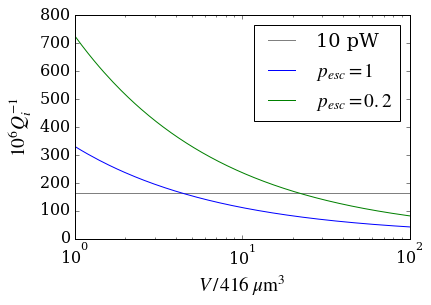

In [23]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel('$V \, / \, 416 \; \mu \mathrm{m}^3$')
ax.set_ylabel('$10^6 Q_i^{-1}$')

ax.axhline(1e6 * max_mean_iQi, color='gray', label='10 pW')

ax.plot(V / nominal_volume_um3,
        1e6 * kid1.iQi(Gamma=Gamma_max), label='$p_{esc} = 1$')

ax.plot(V / nominal_volume_um3,
        1e6 * kid5.iQi(Gamma=Gamma_max), label='$p_{esc} = 0.2$')

ax.legend(loc='best');

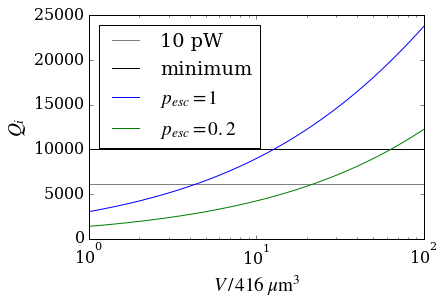

In [24]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel('$V \, / \, 416 \; \mu \mathrm{m}^3$')
ax.set_ylabel('$Q_i$')

ax.axhline(1 / max_mean_iQi, color='gray', label='10 pW')
ax.axhline(1e4, color='black', label='minimum')

ax.plot(V / nominal_volume_um3,
        1 / kid1.iQi(Gamma=Gamma_max), label='$p_{esc} = 1$')

ax.plot(V / nominal_volume_um3,
        1 / kid5.iQi(Gamma=Gamma_max), label='$p_{esc} = 0.2$')

ax.legend(loc='best');